In [1]:
import pandas as pd 
import dask.dataframe as dd
# import pyarrow as pa
import numpy as np
import tqdm
from datetime import datetime as dt
# from tsfresh.feature_extraction import extract_features
from pymongo import MongoClient
from sklearn.model_selection import train_test_split
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot
import scipy
import seaborn
import jieba
# jieba.enable_parallel(4)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import svm
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.preprocessing import StandardScaler
from tsfresh import extract_features 

import lightgbm as lgbm

In [2]:
collection = MongoClient('52.68.95.18:27017')['BTCUSD_order_book']['binance_order_book']

In [3]:
order_book_df = pd.DataFrame(list(collection.find({})))

In [4]:
order_book_df.head(3)

,_id,asks,bids,buy_ratio,buy_volume,datetime,last_price,market_pair,sell_ratio,sell_volume,timestamp,total_buy_btc,total_sell_btc,updatetime
0,5d25872298c3b168ff54531a,"[[12978.36000000, 0.03030600], [12979.76000000...","[[12976.66000000, 0.10164700], [12976.64000000...",30.97667173765498,1.316381e+07,2019-07-10 14:35:11,12978.36000000,BTCUSD,0.03228235778424215,426686.081657,1562740511,1016.818264,32.825291,2019-07-10 14:35:13
1,5d25881298c3b168ff54539a,"[[12968.46000000, 0.13648400], [12968.47000000...","[[12967.35000000, 0.03035800], [12967.33000000...",32.04501619267269,1.283020e+07,2019-07-10 14:39:11,12967.35000000,BTCUSD,0.031206100630046075,401769.292752,1562740751,991.114025,30.928804,2019-07-10 14:39:13
2,5d25882398c3b168ff5453bc,"[[12969.00000000, 0.39608300], [12969.98000000...","[[12967.38000000, 1.00000000], [12967.37000000...",29.928371958159985,1.288608e+07,2019-07-10 14:39:29,12969.00000000,BTCUSD,0.033413110522617306,432191.347667,1562740769,995.424056,33.260214,2019-07-10 14:39:29


In [5]:
order_book_df.drop(['market_pair', 'datetime', 'timestamp'], axis=1 , inplace=True)

In [6]:
ticker_collection = MongoClient('52.68.95.18:27017')['BTCUSD_order_book']['binance_ticker']

In [7]:
ticker_df = pd.DataFrame(list(ticker_collection.find({})))

In [8]:
for column in ['askPrice', 'askQty', 'bidPrice', 'bidQty']:
    ticker_df[column] = ticker_df[column].astype(float)

In [9]:
ticker_df.head(3)

,_id,askPrice,askQty,bidPrice,bidQty,closeTime,count,datetime,firstId,highPrice,...,openTime,prevClosePrice,priceChange,priceChangePercent,quoteVolume,symbol,timestamp,updatetime,volume,weightedAvgPrice
0,5d25872298c3b168ff545312,12978.36,0.031418,12976.66,0.101647,1562740514133,707346,2019-07-10 14:35:11,151090107,13110.10000000,...,1562654114133,12682.42000000,297.05000000,2.343,1064347327.48953093,BTCUSDT,1562740511,2019-07-10 14:35:13,84667.66264700,12570.88354886
1,5d25881298c3b168ff545392,12968.46,0.136484,12967.35,0.030358,1562740753480,706286,2019-07-10 14:39:11,151092126,13110.10000000,...,1562654353480,12660.35000000,307.00000000,2.425,1063256693.22454173,BTCUSDT,1562740751,2019-07-10 14:39:13,84579.36503600,12571.11226565
2,5d25882298c3b168ff5453b4,12969.00,0.396083,12967.38,1.000000,1562740770433,706263,2019-07-10 14:39:29,151092192,13110.10000000,...,1562654370433,12670.82000000,300.24000000,2.370,1063251345.09378180,BTCUSDT,1562740769,2019-07-10 14:39:29,84578.87919500,12571.12124461


In [10]:
ticker_df.drop(['market_pair', 'symbol', 'timestamp', 'datetime','closeTime','count','firstId','lastId','openTime','weightedAvgPrice'], axis=1, inplace=True)

In [11]:
ticker_df['askBidMean'] = (ticker_df['askPrice'] + ticker_df['bidPrice'])/2

In [12]:
train_df = pd.merge(order_book_df, ticker_df, on='updatetime')

In [13]:
lst_ = []
lst_2 = []
for i in train_df['asks']:
    data = {}
    total_volume = 0
    for counter, k in enumerate(i):
        total_volume += float(k[1])
    data["asks_order_book_top_100"] = total_volume
    data["asks_order_book_top_100_spread"] = float(i[0][0]) - float(i[-1][0])
    lst_.append(data)
    
for i in train_df['bids']:
    data = {}
    total_volume = 0
    for counter, k in enumerate(i):
        total_volume += float(k[1])
    data["bids_order_book_top_100"] = total_volume
    data["bids_order_book_top_100_spread"] = float(i[0][0]) - float(i[-1][0])
    lst_2.append(data)

In [14]:
train_df = pd.concat([pd.DataFrame(lst_), pd.DataFrame(lst_2), train_df],axis=1)

In [15]:
train_df['minute'] = train_df['updatetime'].apply(lambda x: 3 * (dt.strptime(x,"%Y-%m-%d %H:%M:%S").minute // 3))
train_df['quarter_hour_time'] = train_df[['updatetime','minute']].apply(lambda x: dt.strftime(dt.strptime(x['updatetime'],"%Y-%m-%d %H:%M:%S").replace(minute=x['minute']),"%Y-%m-%d %H:%M"), axis=1)
train_df['hour'] = train_df['updatetime'].apply(lambda x: dt.strptime(x,"%Y-%m-%d %H:%M:%S").hour)
train_df['buy_sell_ratio'] = train_df['sell_volume'] / train_df['buy_volume']
# train_df['askBidMean_log'] = np.log(train_df['askBidMean'])
# train_df['total_sell_btc_log'] = np.log(train_df['total_sell_btc'])
# train_df['total_buy_btc_log'] = np.log(train_df['total_buy_btc'])
# train_df['volume_log'] = np.log(train_df['volume'])
# train_df['buy_volume_log'] = np.log(train_df['buy_volume'])

In [16]:
train_df = train_df.iloc[4:]

In [17]:
for column in ['buy_ratio', 'buy_volume', 'last_price',
       'sell_ratio', 'sell_volume', 'total_buy_btc', 'total_sell_btc',
       'askPrice', 'askQty', 'bidPrice', 'bidQty',
       'highPrice', 'lastPrice', 'lastQty', 'lowPrice', 'openPrice',
       'prevClosePrice', 'priceChange', 'priceChangePercent', 'quoteVolume',
       'volume', 'askBidMean', 'hour']:
    train_df[column] = train_df[column].astype(float)

In [18]:
# train_df['ratio__multi'] = train_df['buy_ratio']*train_df['sell_ratio']

In [19]:
fcp = {
        'fft_coefficient': [{'coeff': 0, 'attr': 'abs'}],
        'absolute_sum_of_changes':None,
        'standard_deviation':None,
#         'minimum':None
#         'kurtosis':None,
#         'skewness':None,
#         'median':None,
#         'number_peaks' : [{'n':10}],
#         'variance_larger_than_standard_deviation':None,
#         'count_above_mean':None,
#         'longest_strike_above_mean':None
}
# aggdfts = extract_features(train_df, column_id='quarter_hour_time', column_sort='updatetime',column_value = 'total_sell_btc',default_fc_parameters=fcp,n_jobs=2)
# aggdfts2 = extract_features(train_df, column_id='quarter_hour_time', column_sort='updatetime',column_value = 'total_buy_btc',default_fc_parameters=fcp,n_jobs=2)
# aggdfts3 = extract_features(train_df, column_id='quarter_hour_time', column_sort='updatetime',column_value = 'volume',default_fc_parameters=fcp,n_jobs=2)
# aggdfts4 = extract_features(train_df, column_id='quarter_hour_time', column_sort='updatetime',column_value = 'askBidMean',default_fc_parameters=fcp,n_jobs=2)
# aggdfts5 = extract_features(train_df, column_id='quarter_hour_time', column_sort='updatetime',column_value = 'sell_volume',default_fc_parameters=fcp,n_jobs=2)
# aggdfts6 = extract_features(train_df, column_id='quarter_hour_time', column_sort='updatetime',column_value = 'buy_volume',default_fc_parameters=fcp,n_jobs=2)
# aggdfts7 = extract_features(train_df, column_id='quarter_hour_time', column_sort='updatetime',column_value = 'buy_ratio',default_fc_parameters=fcp,n_jobs=2)
# aggdfts8 = extract_features(train_df, column_id='quarter_hour_time', column_sort='updatetime',column_value = 'sell_ratio',default_fc_parameters=fcp,n_jobs=2)

In [20]:
y = train_df.groupby("quarter_hour_time").last()['askBidMean']

In [21]:
# cleanData = pd.concat([groupby1],axis=1)
# cleanData = cleanData.join(aggdfts, on='datetime_hour')
# cleanData = cleanData.join(aggdfts2, on='datetime_hour')
# cleanData = cleanData.join(aggdfts3, on='datetime_hour')
# cleanData = cleanData.join(aggdfts5, on='datetime_hour')
# cleanData = cleanData.join(aggdfts6, on='datetime_hour')
# cleanData = cleanData.join(aggdfts7, on='datetime_hour')
# cleanData = cleanData.join(aggdfts8, on='datetime_hour')
# cleanData = groupby.drop(['asks', 'bids', '_id_y', 'updatetime','_id_x'], axis=1)
# cleanData = cleanData.drop(['asks', 'bids', 'updatetime','_id_y', '_id_x'], axis=1)

In [22]:
train_df.columns

Index(['asks_order_book_top_100', 'asks_order_book_top_100_spread',
       'bids_order_book_top_100', 'bids_order_book_top_100_spread', '_id_x',
       'asks', 'bids', 'buy_ratio', 'buy_volume', 'last_price', 'sell_ratio',
       'sell_volume', 'total_buy_btc', 'total_sell_btc', 'updatetime', '_id_y',
       'askPrice', 'askQty', 'bidPrice', 'bidQty', 'highPrice', 'lastPrice',
       'lastQty', 'lowPrice', 'openPrice', 'prevClosePrice', 'priceChange',
       'priceChangePercent', 'quoteVolume', 'volume', 'askBidMean', 'minute',
       'quarter_hour_time', 'hour', 'buy_sell_ratio'],
      dtype='object')

In [23]:
cleanData = train_df.groupby('quarter_hour_time').agg({
#     "sell_ratio":['mean'],
#     'buy_ratio':['mean'], 
    'buy_volume':['mean'], 
#     'buy_sell_ratio':['mean','max','min'],
#     'last_price':['max'],
#     'sell_ratio':['max'], 
    'sell_volume':['mean'], 
    'total_buy_btc':['mean', 'max', 'min'], 
    'total_sell_btc':['mean', 'max', 'min'],
#     'askPrice':['max'], 
#     'askQty':['max'], 
#     'bidPrice':['max'], 
#     'bidQty':['max'],
#     'highPrice':['max'], 
#     'lastPrice':['max'], 
#     'lastQty':['max'], 
#     'lowPrice':['max'], 
#     'openPrice':['max'],
#     'prevClosePrice':['max'], 
#     'priceChange':['max'], 
#     'priceChangePercent':['max'], 
#     'quoteVolume':['max'],
    'bids_order_book_top_100':['max','min','std'],
    'asks_order_book_top_100':['max','min'],
    'bids_order_book_top_100_spread':['max','min'],
    'asks_order_book_top_100_spread':['max','min'],
    'buy_sell_ratio':['max','min'],
    'volume':['mean','min'], 
    'askBidMean':['mean','max','min'], 
#     'hour':['mean'],
})

In [24]:
cleanData['askBidSpread'] = (cleanData['askBidMean']['max'] - cleanData['askBidMean']['min']) / cleanData['askBidMean']['mean']
cleanData['askBidDiff'] = (cleanData['askBidMean']['max'] - cleanData['askBidMean']['min'])
cleanData['buySellRatioDiff'] = (cleanData['buy_sell_ratio']['max'] - cleanData['buy_sell_ratio']['min'])
cleanData['asks_top100Diff'] = (cleanData['asks_order_book_top_100']['max'] - cleanData['asks_order_book_top_100']['min'])
cleanData['bids_top100Diff'] = (cleanData['bids_order_book_top_100']['max'] - cleanData['bids_order_book_top_100']['min'])
cleanData['bids_top100_spreadDiff'] = (cleanData['bids_order_book_top_100_spread']['max'] - cleanData['bids_order_book_top_100_spread']['min'])
cleanData['asks_top100_spreadDiff'] = (cleanData['asks_order_book_top_100_spread']['max'] - cleanData['asks_order_book_top_100_spread']['min'])
cleanData['totalbuy_diff'] = (cleanData['total_buy_btc']['max'] - cleanData['total_buy_btc']['min'])
cleanData['totalsell_diff'] = (cleanData['total_sell_btc']['max'] - cleanData['total_sell_btc']['min'])

In [25]:
# cleanData['volumne_diff'] = (train_df.groupby("datetime_hour")['volume'].max()-train_df.groupby("datetime_hour")['volume'].min())
# cleanData['volumne_ratio'] = (train_df.groupby("datetime_hour")['volume'].max()-train_df.groupby("datetime_hour")['volume'].median())/train_df.groupby("datetime_hour")['volume'].mean()
# cleanData['askBidMean_diff'] = (train_df.groupby("datetime_hour")['askBidMean'].max()-train_df.groupby("datetime_hour")['askBidMean'].min())/train_df.groupby("datetime_hour")['askBidMean'].mean()
# cleanData['ratio_multi'] = train_df.groupby("datetime_hour")['sell_ratio'].mean()*train_df.groupby("datetime_hour")['buy_ratio'].mean()
# cleanData['ratio_std_multi'] = train_df.groupby("datetime_hour")['total_sell_btc'].std()*train_df.groupby("datetime_hour")['total_buy_btc'].std()

In [26]:
x_window, y_window = 3, 2

x = np.zeros((len(cleanData)-x_window-y_window+1,x_window, len(cleanData.columns)))

y_mean = np.zeros(len(cleanData)-x_window-y_window+1)

cleanDataX = np.asarray(cleanData)
cleanDataY = np.asarray(y)

# scaler = StandardScaler()
# scaler.fit(cleanDataX)
# cleanDataX = scaler.transform(cleanDataX)

for index, i in enumerate(cleanDataX):
    x[index] = cleanDataX[index:index+x_window]
    y_mean[index] = cleanDataY[(index+x_window+y_window-1):(index+x_window+y_window)].mean()
    if index+x_window+y_window == len(cleanDataX):
        break

In [27]:
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation, Flatten, Dropout, GRU, Input, Bidirectional
from keras.layers import Embedding
from keras.optimizers import Adam, RMSprop
from keras.models import Model
import matplotlib.pyplot as plt

Using TensorFlow backend.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[2918]	valid_0's l2: 1596.16	valid_0's rmse: 39.952	valid_1's l2: 228167	valid_1's rmse: 477.668


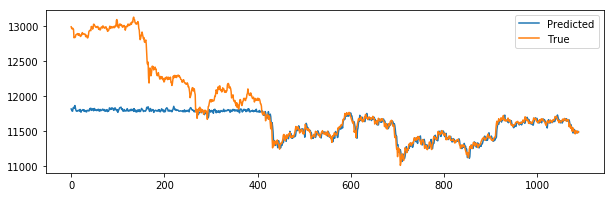

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[211]	valid_0's l2: 2480.88	valid_0's rmse: 49.8084	valid_1's l2: 2062.43	valid_1's rmse: 45.414


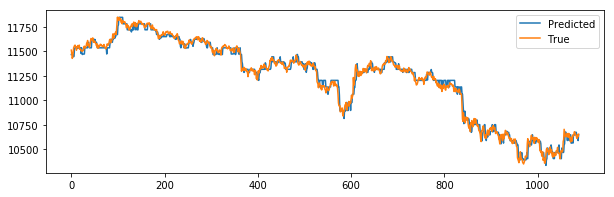

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[989]	valid_0's l2: 1755.89	valid_0's rmse: 41.9033	valid_1's l2: 4572.42	valid_1's rmse: 67.6197


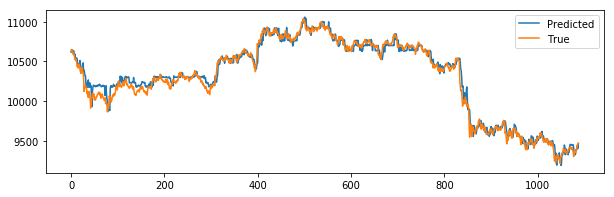

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[804]	valid_0's l2: 1803.96	valid_0's rmse: 42.4731	valid_1's l2: 3612.19	valid_1's rmse: 60.1015


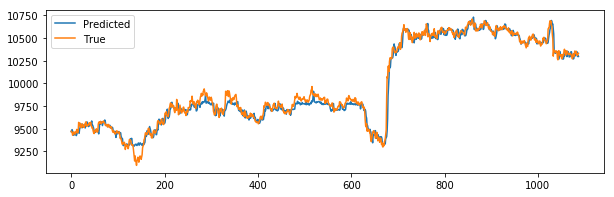

In [28]:
clfs = []
stratified_folder = KFold(n_splits=4, random_state=42, shuffle=False) 
for train_index, test_index in stratified_folder.split(x,y_mean): 
    X_train, X_test = x[train_index].reshape(x[train_index].shape[0],-1), x[test_index].reshape(x[test_index].shape[0],-1)
    y_train, y_test = y_mean[train_index], y_mean[test_index] 
    lgb_params = {
        'boosting_type': 'gbdt',
        'num_leaves':2,
        'objective': 'regression',
        'metric': 'mse',
        'subsample': .7,
        'colsample_bytree': .5,
        'reg_alpha': .1,
        'max_bin':500,
        'reg_lambda': .1,
        'min_split_gain': 1,
        'min_child_weight': 1,
        'silent':True,
        'verbosity':-1,
        'n_jobs':3
    }

    clf = lgbm.LGBMRegressor(**lgb_params,learning_rate=0.05,
                                    n_estimators=10000,max_depth=2)
    clf.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train),(X_test, y_test)],
        verbose=-1,
        eval_metric='rmse',
        early_stopping_rounds=100
    )
    clfs.append(clf)
    clf_pred = clf.predict(X_test, num_iteration=clf.best_iteration_)
    
    plt.figure(figsize=(10,3))
    plt.plot(range(len(clf_pred)), clf_pred)
    plt.plot(range(len(clf_pred)), y_test)
    plt.legend(['Predicted','True'])
    plt.show()
#     print("predict ")
#     print(pred)
#     print("true ")
#     print(y_test)
#     print(f1_score(pred, y_test, average='macro'))
#     print(confusion_matrix(pred, y_test))

Train on 3265 samples, validate on 1089 samples
Epoch 1/100
 - 1s - loss: 106623479.6545 - val_loss: nan
Epoch 2/100
 - 0s - loss: 93517672.9237 - val_loss: nan
Epoch 3/100
 - 0s - loss: 77047995.2392 - val_loss: nan
Epoch 4/100
 - 0s - loss: 58828155.6876 - val_loss: nan
Epoch 5/100
 - 0s - loss: 39933540.1286 - val_loss: nan
Epoch 6/100
 - 0s - loss: 22390743.1933 - val_loss: nan
Epoch 7/100
 - 0s - loss: 8831370.3161 - val_loss: nan
Epoch 8/100
 - 0s - loss: 1918111.4719 - val_loss: nan
Epoch 9/100
 - 0s - loss: 1164606.4491 - val_loss: nan
Epoch 10/100
 - 0s - loss: 1061229.0705 - val_loss: nan
Epoch 11/100
 - 0s - loss: 990937.1339 - val_loss: nan
Epoch 12/100
 - 0s - loss: 959917.5324 - val_loss: nan
Epoch 13/100
 - 0s - loss: 933375.6783 - val_loss: nan
Epoch 14/100
 - 0s - loss: 913464.1380 - val_loss: nan
Epoch 15/100
 - 0s - loss: 863853.1047 - val_loss: nan
Epoch 16/100
 - 0s - loss: 865155.9992 - val_loss: nan
Epoch 17/100
 - 0s - loss: 851219.7614 - val_loss: nan
Epoch 18/

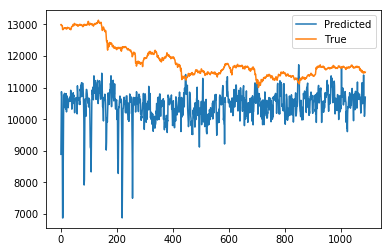

Train on 3265 samples, validate on 1089 samples
Epoch 1/100
 - 1s - loss: nan - val_loss: nan
Epoch 2/100
 - 0s - loss: nan - val_loss: nan
Epoch 3/100
 - 0s - loss: nan - val_loss: nan
Epoch 4/100
 - 0s - loss: nan - val_loss: nan
Epoch 5/100
 - 0s - loss: nan - val_loss: nan
Epoch 6/100
 - 0s - loss: nan - val_loss: nan
Epoch 7/100
 - 0s - loss: nan - val_loss: nan
Epoch 8/100
 - 0s - loss: nan - val_loss: nan
Epoch 9/100
 - 0s - loss: nan - val_loss: nan
Epoch 10/100
 - 0s - loss: nan - val_loss: nan
Epoch 11/100
 - 0s - loss: nan - val_loss: nan
Epoch 12/100
 - 0s - loss: nan - val_loss: nan
Epoch 13/100
 - 0s - loss: nan - val_loss: nan
Epoch 14/100
 - 0s - loss: nan - val_loss: nan
Epoch 15/100
 - 0s - loss: nan - val_loss: nan
Epoch 16/100
 - 0s - loss: nan - val_loss: nan
Epoch 17/100
 - 0s - loss: nan - val_loss: nan
Epoch 18/100
 - 0s - loss: nan - val_loss: nan
Epoch 19/100
 - 0s - loss: nan - val_loss: nan
Epoch 20/100
 - 0s - loss: nan - val_loss: nan
Epoch 21/100
 - 0s - 

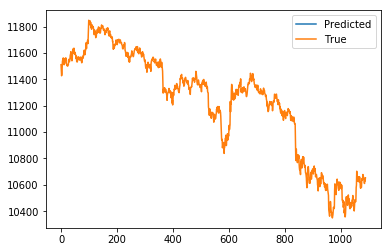

Train on 3266 samples, validate on 1088 samples
Epoch 1/100
 - 1s - loss: nan - val_loss: nan
Epoch 2/100
 - 0s - loss: nan - val_loss: nan
Epoch 3/100
 - 0s - loss: nan - val_loss: nan
Epoch 4/100
 - 0s - loss: nan - val_loss: nan
Epoch 5/100
 - 0s - loss: nan - val_loss: nan
Epoch 6/100
 - 0s - loss: nan - val_loss: nan
Epoch 7/100
 - 0s - loss: nan - val_loss: nan
Epoch 8/100
 - 0s - loss: nan - val_loss: nan
Epoch 9/100
 - 0s - loss: nan - val_loss: nan
Epoch 10/100
 - 0s - loss: nan - val_loss: nan
Epoch 11/100
 - 0s - loss: nan - val_loss: nan
Epoch 12/100
 - 0s - loss: nan - val_loss: nan
Epoch 13/100
 - 0s - loss: nan - val_loss: nan
Epoch 14/100
 - 0s - loss: nan - val_loss: nan
Epoch 15/100
 - 0s - loss: nan - val_loss: nan
Epoch 16/100
 - 0s - loss: nan - val_loss: nan
Epoch 17/100
 - 0s - loss: nan - val_loss: nan
Epoch 18/100
 - 0s - loss: nan - val_loss: nan
Epoch 19/100
 - 0s - loss: nan - val_loss: nan
Epoch 20/100
 - 0s - loss: nan - val_loss: nan
Epoch 21/100
 - 0s - 

KeyboardInterrupt: 

In [29]:
jumpto = 0
stratified_folder = KFold(n_splits=4, random_state=0, shuffle=False) 
for train_index, test_index in stratified_folder.split(x,y_mean): 
    X_train, X_test = x[train_index], x[test_index]
    y_train_mean, y_test_mean = y_mean[train_index], y_mean[test_index]
    
    input_layer = Input(shape=(X_train.shape[1],X_train.shape[2]))
    hidden_layer = GRU(64, return_sequences=True, activation='tanh')(input_layer)
#     hidden_layer = GRU(64, return_sequences=True, activation='tanh')(hidden_layer)
#     hidden_layer = GRU(64, return_sequences=True, activation='tanh')(hidden_layer)
#     hidden_layer = GRU(32, return_sequences=True, activation='tanh', stateful=False)(hidden_layer)
    
    hidden_layer = Flatten()(hidden_layer)
    
    hidden_layer = Dense(1024, activation='relu')(hidden_layer)
    hidden_layer = Dropout(0.5)(hidden_layer)
#     hidden_layer = Dense(256, activation='relu')(hidden_layer)
#     hidden_layer = Dropout(0.5)(hidden_layer)
    
#     mean_hidden_layer = Dense(2048, activation='relu')(mean_hidden_layer)
#     mean_hidden_layer = Dropout(0.1)(mean_hidden_layer)
#     max_hidden_layer = Dense(256, activation='relu')(hidden_layer)
#     max_hidden_layer = Dropout(0.1)(max_hidden_layer)
    
#     min_hidden_layer = Dense(256, activation='relu')(hidden_layer)
#     min_hidden_layer = Dropout(0.1)(min_hidden_layer)
    
    output_layer_1 = Dense(1,activation='linear')(hidden_layer)
#     output_layer_2 = Dense(1,activation='linear')(max_hidden_layer)
#     output_layer_3 = Dense(1,activation='linear')(min_hidden_layer)
    
    opt = RMSprop(lr=0.005,clipnorm=1)
    
    ml_model = Model(inputs=input_layer, outputs=[output_layer_1])
    ml_model.compile(optimizer=opt, loss='mse')
    ml_model.fit(X_train, y_train_mean, validation_data=(X_test, y_test_mean), epochs=100, verbose=2, batch_size=333)
    
    ml_pred = ml_model.predict(X_test, batch_size=333)

    plt.plot(range(len(ml_pred)), ml_pred)
    plt.plot(range(len(ml_pred)), y_test_mean)
    plt.legend(['Predicted','True'])
    plt.show()
#     break
#     print(f1_score(pred, y_test, average='macro'))
#     print(confusion_matrix(pred, y_test))

In [30]:
order_book_df = pd.DataFrame(list(collection.find({"updatetime":{"$gte":"2019-07-19 18:20"}})))
order_book_df.drop(['market_pair', 'datetime', 'timestamp'], axis=1 , inplace=True)
ticker_df = pd.DataFrame(list(ticker_collection.find({"updatetime":{"$gte":"2019-07-19 18:20"}})))
for column in ['askPrice', 'askQty', 'bidPrice', 'bidQty']:
    ticker_df[column] = ticker_df[column].astype(float)
ticker_df.drop(['market_pair', 'symbol', 'timestamp', 'datetime','closeTime','count','firstId','lastId','openTime','weightedAvgPrice'], axis=1, inplace=True)
ticker_df['askBidMean'] = (ticker_df['askPrice'] + ticker_df['bidPrice'])/2
train_df = pd.merge(order_book_df, ticker_df, on='updatetime')

In [31]:
lst_ = []
lst_2 = []
for i in train_df['asks']:
    data = {}
    total_volume = 0
    for counter, k in enumerate(i):
        total_volume += float(k[1])
    data["asks_order_book_top_100"] = total_volume
    data["asks_order_book_top_100_spread"] = float(i[0][0]) - float(i[-1][0])
    lst_.append(data)
    
for i in train_df['bids']:
    data = {}
    total_volume = 0
    for counter, k in enumerate(i):
        total_volume += float(k[1])
    data["bids_order_book_top_100"] = total_volume
    data["bids_order_book_top_100_spread"] = float(i[0][0]) - float(i[-1][0])
    lst_2.append(data)

In [32]:
train_df = pd.concat([pd.DataFrame(lst_), pd.DataFrame(lst_2), train_df],axis=1)

In [33]:
train_df['minute'] = train_df['updatetime'].apply(lambda x: 2 * (dt.strptime(x,"%Y-%m-%d %H:%M:%S").minute //2))
train_df['quarter_hour_time'] = train_df[['updatetime','minute']].apply(lambda x: dt.strftime(dt.strptime(x['updatetime'],"%Y-%m-%d %H:%M:%S").replace(minute=x['minute']),"%Y-%m-%d %H:%M"), axis=1)
train_df['hour'] = train_df['updatetime'].apply(lambda x: dt.strptime(x,"%Y-%m-%d %H:%M:%S").hour)
train_df['buy_sell_ratio'] = train_df['sell_volume'] / train_df['buy_volume']

In [34]:
for column in ['buy_ratio', 'buy_volume', 'last_price',
       'sell_ratio', 'sell_volume', 'total_buy_btc', 'total_sell_btc',
       'askPrice', 'askQty', 'bidPrice', 'bidQty',
       'highPrice', 'lastPrice', 'lastQty', 'lowPrice', 'openPrice',
       'prevClosePrice', 'priceChange', 'priceChangePercent', 'quoteVolume',
       'volume', 'askBidMean', 'hour']:
    train_df[column] = train_df[column].astype(float)

In [35]:
cleanData = train_df.groupby('quarter_hour_time').agg({
#     "sell_ratio":['mean'],
#     'buy_ratio':['mean'], 
    'buy_volume':['mean'], 
#     'buy_sell_ratio':['mean','max','min'],
#     'last_price':['max'],
#     'sell_ratio':['max'], 
    'sell_volume':['mean'], 
    'total_buy_btc':['mean', 'max', 'min'], 
    'total_sell_btc':['mean', 'max', 'min'],
#     'askPrice':['max'], 
#     'askQty':['max'], 
#     'bidPrice':['max'], 
#     'bidQty':['max'],
#     'highPrice':['max'], 
#     'lastPrice':['max'], 
#     'lastQty':['max'], 
#     'lowPrice':['max'], 
#     'openPrice':['max'],
#     'prevClosePrice':['max'], 
#     'priceChange':['max'], 
#     'priceChangePercent':['max'], 
#     'quoteVolume':['max'],
    'bids_order_book_top_100':['max','min','std'],
    'asks_order_book_top_100':['max','min'],
    'bids_order_book_top_100_spread':['max','min'],
    'asks_order_book_top_100_spread':['max','min'],
    'buy_sell_ratio':['max','min'],
    'volume':['mean','min'], 
    'askBidMean':['mean','max','min'], 
#     'hour':['mean'],
})

In [36]:
cleanData['askBidSpread'] = (cleanData['askBidMean']['max'] - cleanData['askBidMean']['min']) / cleanData['askBidMean']['mean']
cleanData['askBidDiff'] = (cleanData['askBidMean']['max'] - cleanData['askBidMean']['min'])
cleanData['buySellRatioDiff'] = (cleanData['buy_sell_ratio']['max'] - cleanData['buy_sell_ratio']['min'])
cleanData['asks_top100Diff'] = (cleanData['asks_order_book_top_100']['max'] - cleanData['asks_order_book_top_100']['min'])
cleanData['bids_top100Diff'] = (cleanData['bids_order_book_top_100']['max'] - cleanData['bids_order_book_top_100']['min'])
cleanData['bids_top100_spreadDiff'] = (cleanData['bids_order_book_top_100_spread']['max'] - cleanData['bids_order_book_top_100_spread']['min'])
cleanData['asks_top100_spreadDiff'] = (cleanData['asks_order_book_top_100_spread']['max'] - cleanData['asks_order_book_top_100_spread']['min'])
cleanData['totalbuy_diff'] = (cleanData['total_buy_btc']['max'] - cleanData['total_buy_btc']['min'])
cleanData['totalsell_diff'] = (cleanData['total_sell_btc']['max'] - cleanData['total_sell_btc']['min'])

In [37]:
cleanData.tail(3)

buy_volume    sell_volume total_buy_btc             \
                            mean           mean          mean        max   
quarter_hour_time                                                          
2019-07-19 19:04   436705.172573  293746.033227     42.413373  49.950644   
2019-07-19 19:06   374846.729078  147476.719922     36.402850  37.687277   
2019-07-19 19:08   429117.729020  151525.766588     41.640841  41.640841   

                             total_sell_btc                        \
                         min           mean        max        min   
quarter_hour_time                                                   
2019-07-19 19:04   36.577798      28.433176  53.818266  15.420124   
2019-07-19 19:06   34.960441      14.261421  15.235011  12.957062   
2019-07-19 19:08   41.640841      14.653742  14.653742  14.653742   

                  bids_order_book_top_100             ... askBidMean  \
                                      max        min  ...        min   
quarter_hour_time                                     ...              
2019-07-19 19:04                49.950644  36.577798  ...  10316.405   
2019-07-19 19:06                37.687277  34.960441  ...  10323.860   
2019-07-19 19:08                41.640841  41.640841  ...  10328.385   

                  askBidSpread askBidDiff buySellRatioDiff asks_top100Diff  \
                                                                             
quarter_hour_time                                                            
2019-07-19 19:04      0.001248     12.885         0.897826       38.398142   
2019-07-19 19:06      0.000641      6.620         0.044588        2.277949   
2019-07-19 19:08      0.000000      0.000         0.000000        0.000000   

                  bids_top100Diff bids_top100_spreadDiff  \
                                                           
quarter_hour_time                                          
2019-07-19 19:04        13.372846                  11.69   
2019-07-19 19:06         2.726836                   8.71   
2019-07-19 19:08         0.000000                   0.00   

                  asks_top100_spreadDiff totalbuy_diff totalsell_diff  
                                                                       
quarter_hour_time                                                      
2019-07-19 19:04                    6.54     13.372846      38.398142  
2019-07-19 19:06                    3.72      2.726836       2.277949  
2019-07-19 19:08                    0.00      0.000000       0.000000  

[3 rows x 33 columns]

In [38]:
x = np.zeros((len(cleanData)-x_window+1, x_window, len(cleanData.columns)))

cleanDataX = np.asarray(cleanData)

for index, i in enumerate(cleanDataX):
    x[index] = cleanDataX[index:index+x_window]
    if index+x_window >= len(cleanDataX):
        break

In [ ]:
test = np.zeros((len(x)))
for clf in clfs:
    test += clf.predict(x.reshape(x.shape[0],-1)) / len(clfs)
test